In [68]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# DCGAN 튜토리얼

**저자**: [Nathan Inkawhich](https://github.com/inkawhich)
**번역**: [조민성](https://github.com/miNept)


## 개요

본 튜토리얼에서는 예제를 통해 DCGAN을 알아보겠습니다. 우리는 실제 유명인들의 사진들로 적대적 생성 신경망(GAN)을 학습시켜,
새로운 유명인의 사진을 만들어보겠습니다.
사용할 대부분의 코드는 [pytorch/examples](https://github.com/pytorch/examples)_ 의 DCGAN 구현에서 가져왔으며,
본 문서는 구현에 대한 설명과 함께, 어째서 이 모델이 작동하는지에 대해 설명을 해줄 것입니다.
처음 읽었을때는, 실제로 모델에 무슨일이 일어나고 있는지에 대해 이해하는 것이 조금 시간을 소요할 수 있으나,
그래도 GAN에 대한 사전지식이 필요하지는 않으니 걱정하지 않으셔도 됩니다.
추가로, GPU 1-2개를 사용하는 것이 시간절약에 도움이 될겁니다. 그럼 처음부터 천천히 시작해봅시다!

## 적대적 생성 신경망(Generative Adversarial Networks)

### 그래서 GAN이 뭘까요?

GAN이란 학습 데이터들의 분포를 학습한 뒤, 동일한 분포를 갖는 새로운 데이터를
생성하도록 딥러닝 모델을 학습시키는 프레임워크입니다.
GAN은 2014년 Ian Goodfellow가 개발했으며,
[Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_ 논문에서
처음 소개되었습니다.
GAN은 *생성자(Generator)* 와 *구분자(Discriminator)* 라는 두 개의 서로
다른(distinct) 모델들로 구성되어 있습니다.
생성자(Generator)의 역할은 학습한 이미지들과 같아 보이는 `가짜(fake)`
이미지를 만드는 것이고, 구분자(Discriminator)는 이미지를 보고 이것이
실제 학습 데이터에서 가져온 것인지, 또는 생성자에 의해 만들어진 가짜
이미지인지 판별하는 것입니다.
모델을 학습하는 동안 생성자는 더 진짜 같은 가짜 이미지를 만들어내며
구분자를 속이려 하고, 구분자는 진짜 이미지와 가짜 이미지를 더 정확히
판별할 수 있도록 노력합니다.
이러한 과정은 생성자가 마치 학습 데이터에서 가져온 것처럼 보이는
완벽한 가짜 이미지를 생성해내고, 판별자는 항상 50%의 신뢰도로
생성자의 출력이 진짜인지 가짜인지 판별할 수 있을 때 균형 상태(equilbrium)에
도달하게 됩니다.

그럼 이제부터 본 튜토리얼에서 사용할 표기들을 구분자부터 정의해보겠습니다.
$x$ 는 이미지로 표현되는 데이터라고 하겠습니다.
$D(x)$ 는 구분자의 신경망을 나타내며, 실제 학습 데이터에서 가져온
$x$ 를 통과시켜 확률 값(scalar)을 결과로 출력합니다.
여기에서는 이미지 데이터를 다루고 있으므로,
$D(x)$ 의 입력으로는 3x64x64 크기의 CHW 이미지가 주어집니다.
직관적으로 $D(x)$ 는 $x$ 가 학습 데이터에서 가져왔을 때 출력이 크고(HIGH),
생성자가 만들어낸 $x$ 일 때는 작을(LOW) 것입니다.
$D(x)$ 는 전통적인 이진 분류기(binary classification)로도 생각할 수도 있습니다.

이번엔 생성자의 표기들을 살펴보겠습니다. $z$ 를 정규분포에서 뽑은
잠재공간 벡터(laten space vector)라고 하겠습니다
(번역 주. laten space vector는 쉽게 생각해 정규분포를 따르는 n개의 원소를 가진 vector라 볼 수 있습니다.
다르게 얘기하면 정규분포에서 n개의 원소를 추출한 것과 같습니다). $G(z)$ 는 $z$
벡터를 원하는 데이터 차원으로 대응시키는 신경망으로 둘 수 있습니다. 이때 $G$ 의 목적은 $p_{data}$
에서 얻을 수 있는 학습 데이터들의 분포를 추정하여, 모사한 $p_g$ 의 분포를 이용해 가짜 데이터들을 만드는 것입니다.

이어서, $D(G(z))$ 는 $G$ 가 출력한 결과물이 실제 이미지 여부를
나타내는 0~1 사이의 확률 값(scalar)입니다.
[Goodfellow의 논문](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_
에 기술되어 있듯이, $D$ 와 $G$ 는 일종의 최대-최소 게임(minimax game)을
하고 있는 것과 같습니다. 이는 $D$ 는 이미지가 진짜인지 가짜인지 여부를 판별하는 확률인
$logD(x)$ 를 최대화하려고 하고, $G$ 는 $D$ 가 가짜라고 판별할 확률인 $log(1-D(G(z)))$ 를
최소화시키려고 하기 때문입니다.
논문에 따르면, GAN의 손실함수는 아래와 같습니다.

\begin{align}\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]\end{align}

이론적으로는, 이 최대-최소 게임의 답(solution)은 $p_g = p_{data}$
일 때이며, 이 때 구분자는 입력이 진짜인지 가짜인지를 무작위로 추측하게
됩니다. 하지만 GAN의 수렴 이론(convergence theory)에 대해서는 아직도
활발히 연구가 진행 중이며, 실제 모델들을 학습할 때에는 항상 이러한
이론적인 최적 상태에 도달하지는 못합니다.

### 그렇다면 DCGAN은 뭘까요?

DCGAN은 위에서 기술한 GAN에서 직접적으로 파생된 모델로, 생성자와 구분자에서
합성곱 신경망(convolution)과 전치 합성곱 신경망(convolution-transpose)을 사용했다는 것이 차이점입니다
Radford와 그 외가 저술한 [Unsupervised Representation Learning With
Deep Convolutional Generative Adversarial
Networks](https://arxiv.org/pdf/1511.06434.pdf)_ 논문에서 처음 모델이 소개되었고, 지금은 대부분의 GAN모델이
DCGAN을 기반으로 만들어지는 중입니다. 이전 GAN과 모델의 구조가 실제로 어떻게 다른지 확인을 해보자면, 먼저 구분자에서는
[convolution](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d)_
계층, [batch
norm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)_
계층, 그리고
[LeakyReLU](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU)_
활성함수가 사용되었습니다. 클래식한 GAN과 마찬가지로, 구분자의 입력 데이터는 3x64x64 의 이미지이고,
출력값은 입력 데이터가 실제 데이터일 0~1사이의 확률값입니다.
다음으로, 생성자는
[convolutional-transpose](https://pytorch.org/docs/stable/nn.html#torch.nn.ConvTranspose2d)_
계층, 배치 정규화(batch norm) 계층, 그리고
[ReLU](https://pytorch.org/docs/stable/nn.html#relu)_ 활성함수가 사용되었습니다.
입력값은 역시나 정규분포에서 추출한 잠재공간 벡터 $z$ 이고, 출력값은 3x64x64 RGB 이미지입니다.
이 때, 전치 합성곱 계층(strided conv-transpose layer)은 잠재공간 벡터로 하여금 이미지와 같은 차원을 갖도록 변환시켜주는 역할을 합니다.
(번역 주. 전치 합성곱 신경망은 합성곱 신경망의 반대적인 개념이라 이해하면 쉽습니다. 입력된 작은 CHW 데이터를 가중치들을 이용해 더 큰 CHW로 업샘플링해주는 계층입니다.)
논문에서는 각종 최적화 방법이나 손실함수의 계산, 모델의 가중치 초기화 방법등에 관한 추가적인 정보들도 적어두었는데,
이 부분은 다음 섹션에서 설명하도록 하겠습니다.



In [69]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 999
#manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # 결과 재현을 위해 필요합니다

Random Seed:  999


In [70]:
pwd

'/content'

## 설정 값

몇 가지 설정 값들을 살펴보겠습니다:

-  ``dataroot`` - 데이터셋 폴더의 경로입니다. 데이터셋에 대해서는 다음 섹션에서
   더 자세히 설명하겠습니다.
-  ``workers`` - ``DataLoader`` 에서 데이터를 불러올 때 사용할 워커 쓰레드의
   수입니다.
-  ``batch_size`` - 학습에 사용할 배치 크기입니다. DCGAN에서는 배치 크기를
   128으로 사용했습니다.
-  ``image_size`` - 학습에 사용하는 이미지의 크기입니다.
   이 튜토리얼에서는 64x64의 크기를 기본으로 하나, 만일 다른 크기의 이미지를
   사용한다면 D와 G의 구조 또한 변경되어야 합니다.
   이에 대해서는 [여기](https://github.com/pytorch/examples/issues/70)_ 를 참고하여
   더 자세한 정보를 확인할 수 있습니다.
-  ``nc`` - 입력 이미지의 색상의 채널 수입니다. RGB 컬러 이미지의 경우
   이 값은 3입니다.
-  ``nz`` - 잠재공간 벡터의 원소들의 수입니다.
-  ``ngf`` - 생성자를 통과할 때 만들어질 특징 데이터의 채널 수입니다.
-  ``ndf`` - 구분자를 통과할 때 만들어질 특징 데이터의 채널 수입니다.
-  ``num_epochs`` - 학습시킬 에폭(epoch) 수입니다. 학습을
   길게하는 경우 대부분 좋은 결과를 보이지만, 이러한 경우 시간 또한
   오래 걸립니다.
-  ``lr`` - 모델의 학습률(learning rate)입니다. DCGAN 논문에서와 같이 0.0002로
   설정합니다.
-  ``beta1`` - Adam 옵티마이저에서 사용할 beta1 하이퍼파라미터 값입니다.
   논문에서와 같이 0.5로 설정했습니다.
-  ``ngpu`` - 사용 가능한 GPU의 개수입니다. 0인 경우에는 코드는 CPU에서 동작합니다.
   만약 이 값이 0보다 큰 경우에는 주어진 수 만큼의 GPU를 사용하여 학습을
   진행합니다.




In [71]:
# 데이터셋의 경로
dataroot = "drive/MyDrive/data/celeba"

# dataloader에서 사용할 쓰레드 수
workers = 2

# 배치 크기
batch_size = 128

# 이미지의 크기입니다. 모든 이미지를 변환하여 64로 크기가 통일됩니다.
image_size = 64

# 이미지의 채널 수로, RGB 이미지이기 때문에 3으로 설정합니다.
nc = 3

# 잠재공간 벡터의 크기 (예. 생성자의 입력값 크기)
nz = 100

# 생성자를 통과하는 특징 데이터들의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터들의 채널 크기
ndf = 64

# 학습할 에폭 수
num_epochs = 50

# 옵티마이저의 학습률
lr = 0.0002

# Adam 옵티마이저의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호. CPU를 사용해야 하는경우 0으로 설정하세요
ngpu = 1

## 데이터

본 튜토리얼에서 사용할 데이터는 [Celeb-A Faces
dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)_ 로, 해당 링크를 이용하거나 [Google
Drive](https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg)_ 에서 데이터를 받을 수 있습니다.
데이터를 받으면 ``img_align_celeba.zip`` 라는 파일을 보게될 겁니다. 다운로드가 끝나면
``celeba`` 이라는 폴더를 새로 만들고, 해당 폴더에 해당 zip 파일을 압축해제 해주시면 됩니다.
압축 해제 후, 위에서 정의한 ``dataroot`` 변수에 방금 만든 ``celeba`` 폴더의 경로를 넣어주세요.
위의 작업이 끝나면 ``celeba`` 폴더의 구조는 다음과 같아야 합니다:

```sh
/path/to/celeba
    -> img_align_celeba
        -> 188242.jpg
        -> 173822.jpg
        -> 284702.jpg
        -> 537394.jpg
           ...
```
이 과정들은 프로그램이 정상적으로 구동하기 위해서는 중요한 부분입니다.
이때 ``celeba`` 폴더 안에 다시 폴더를 두는 이유는,
``ImageFolder`` 클래스가 데이터셋의 최상위 폴더에 서브폴더를 요구하기 때문입니다.
이제 ``Dataset`` 과 ``DataLoader`` 의 설정을 끝냈습니다.
최종적으로 학습 데이터들을 시각화해봅시다.




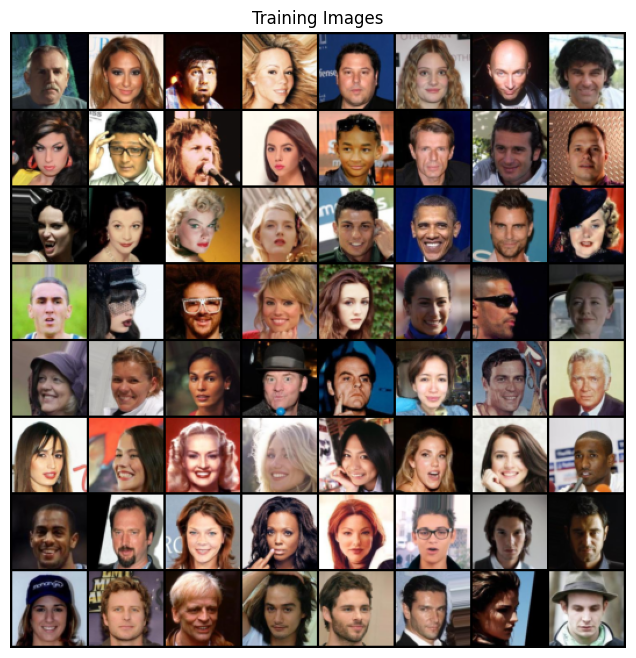

In [72]:
# 우리가 설정한 대로 이미지 데이터셋을 불러와 봅시다
# 먼저 데이터셋을 만듭니다
import os

def is_valid_file(file):
    # 디렉토리가 아니며, 파일이 .ipynb_checkpoints로 끝나지 않는 경우에만 유효
    return not os.path.isdir(file) and not file.endswith('.ipynb_checkpoints')

#!find drive/MyDrive/data/celeba/ -type d -name '.ipynb_checkpoints' -exec rm -r {} +

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
                           )
"""

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),
                           is_valid_file=is_valid_file
                           )
"""

# dataloader를 정의해봅시다
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# GPU 사용여부를 결정해 줍니다
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 학습 데이터들 중 몇가지 이미지들을 화면에 띄워봅시다
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [73]:
print(f"Number of images in the dataset: {len(dataset)}")

total_images = len(dataloader) * batch_size
print(f"Number of images in the dataloader: {total_images}")

Number of images in the dataset: 52794
Number of images in the dataloader: 52864


## 구현

모델의 설정값들과 데이터들이 준비되었기 때문에, 드디어 모델의 구현으로
들어갈 수 있을 것 같습니다. 먼저 가중치 초기화에 대해 이야기 해보고,
순서대로 생성자, 구분자, 손실 함수, 학습 방법들을 알아보겠습니다.

### 가중치 초기화

DCGAN 논문에서는, 평균이 0( ``mean=0`` )이고 분산이 0.02( ``stdev=0.02`` )인
정규분포을 시용해, 구분자와 생성자 모두 무작위 초기화를 진행하는 것이 좋다고 합니다.
``weights_init`` 함수는 매개변수로 모델을 입력받아,
모든 합성곱 계층, 전치 합성곱 계층, 배치 정규화 계층을, 위에서 말한 조건대로
가중치들을 다시 초기화 시킵니다. 이 함수는 모델이 만들어지자 마자 바로 적용을
시키게 됩니다.



In [74]:
# ``netG`` 와 ``netD`` 에 적용시킬 커스텀 가중치 초기화 함수
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### 생성자

생성자 $G$ 는 잠재 공간 벡터 $z$ 를, 데이터 공간으로
변환시키도록 설계되었습니다. 우리에게 데이터라 함은 이미지이기 때문에,
$z$ 를 데이터공간으로 변환한다는 뜻은, 학습이미지와 같은 사이즈를 가진
RGB 이미지를 생성하는것과 같습니다 (예. 3x64x64).
실제 모델에서는 스트라이드(stride) 2를 가진 전치 합성곱 계층들을 이어서 구성하는데,
각 전치 합성곱 계층 하나당 2차원 배치 정규화 계층과 relu 활성함수를 한 쌍으로 묶어서 사용합니다.
생성자의 마지막 출력 계층에서는 데이터를 tanh 함수에 통과시키는데,
이는 출력 값을 $[-1,1]$ 사이의 범위로 조정하기 위해서 입니다.
이때 배치 정규화 계층을 주목할 필요가 있는데, DCGAN 논문에 의하면,
이 계층이 경사하강법(gradient-descent)의 흐름에 중요한 영향을 미치는 것으로 알려져 있습니다.
아래의 그림은 DCGAN 논문에서 가져온 생성자의 모델 아키텍쳐입니다.

.. figure:: /_static/img/dcgan_generator.png
   :alt: dcgan_generator

우리가 설정값 섹션에서 정의한 값들이 (``nz``, ``ngf``, 그리고
``nc``) 생성자 모델 아키텍쳐에 어떻게 영향을 끼치는지 주목해주세요. ``nz`` 는 z 입력 벡터의
길이, ``ngf`` 는 생성자를 통과하는 특징 데이터의 크기, 그리고 ``nc`` 는 출력 이미지의
채널 개수입니다 (RGB 이미지이기 때문에 3으로 설정을 했습니다).
아래는 생성자의 코드입니다.




In [75]:
# 생성자 코드

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력데이터 Z가 가장 처음 통과하는 전치 합성곱 계층입니다.
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 위의 계층을 통과한 데이터의 크기. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

좋습니다. 이제 우리는 생성자의 인스턴스를 만들고 ``weights_init``
함수를 적용시킬 수 있습니다. 모델의 인스턴스를 출력해서 생성자가
어떻게 구성되어있는지 확인해봅시다.




In [76]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### 구분자

앞서 언급했듯, 구분자 $D$ 는 입력 이미지가 진짜 이미지인지 (혹은 반대로 가짜 이미지인지)
판별하는 전통적인 이진 분류 신경망으로 볼 수 있습니다. 이때 $D$ 는
3x64x64 이미지를 입력받아, Conv2d, BatchNorm2d, 그리고 LeakyReLU 계층을 통과시켜
데이터를 가공시키고, 마지막 출력에서 Sigmoid 함수를 이용하여
0~1 사이의 확률값으로 조정합니다. 이 아키텍쳐는 필요한 경우 더 다양한 레이어를 쌓을 수 있지만,
배치 정규화와 LeakyReLU, 특히 보폭이 있는 (strided) 합성곱 계층을
사용하는 것에는 이유가 있습니다.
DCGAN 논문에서는 보폭이 있는 합성곱 계층을 사용하는 것이 신경망 내에서 스스로의
풀링(Pooling) 함수를 학습하기 때문에, 데이터를 처리하는 과정에서 직접적으로 풀링 계층( MaxPool or AvgPooling)을
사용하는 것보다 더 유리하다고 합니다. 또한 배치 정규화와 leaky relu 함수는 학습과정에서
$G$ 와 $D$ 가 더 효과적인 경사도(gradient)를 얻을 수 있습니다.




In [77]:
# 구분자 코드

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64`` 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

이제 우리는 생성자에 한 것처럼 구분자의 인스턴스를 만들고,
``weights_init`` 함수를 적용시킨 다음, 모델의 구조를 출력해볼 수 있습니다.




In [78]:
# 구분자를 만듭니다
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-GPU를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0( ``mean=0`` ), 분산을 0.02( ``stdev=0.02`` )로 초기화하기 위해
# ``weight_init`` 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


### 손실함수와 옵티마이저

$D$ 와 $G$ 의 설정을 끝냈으니, 이제 손실함수와 옵티마이저를 정하여
학습을 구체화시킬 시간입니다. 손실함수로는 Binary Cross Entropy loss
([BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)_)
를 사용할겁니다. 해당함수는 아래의 식으로 파이토치에 구현되어 있습니다:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

이때, 위의 함수가 로그함수 요소를 정의한 방식을 주의깊게 봐주세요 (예. $log(D(x))$ 와
$log(1-D(G(z)))$). 우린 $y$ 을 조정을 조정하여, BCE 함수에서
사용할 요소를 고를 수 있습니다.
이 부분은 이후에 서술할 학습 섹션에서 다루겠지만, 어떻게 $y$ 를 이용하여
우리가 원하는 요소들만 골라낼 수 있는지 이해하는 것이 먼저입니다 (예. GT labels).

좋습니다. 다음으로 넘어가겠습니다. 참 라벨 (혹은 정답)은 1로 두고, 거짓 라벨 (혹은 오답)은 0으로
두겠습니다. 각 라벨의 값을 정한건 GAN 논문에서 사용된 값들로, GAN을 구성할때의 관례라 할
수 있습니다. 방금 정한 라벨 값들은 추후에 손실값을 계산하는 과정에서 사용될겁니다.
마지막으로, 서로 구분되는 두 옵티마이저를 구성하겠습니다. 하나는 $D$ 를 위한 것,
다른 하나는 $G$ 를 위한 것입니다. DCGAN에 서술된 대로, 두 옵티마이저는 모두 Adam을 사용하고,
학습률은 0.0002, Beta1 값은 0.5로 둡니다. 추가적으로, 학습이 진행되는 동안 생성자의 상태를 알아보기 위하여,
프로그램이 끝날때까지 고정된 잠재공간 벡터를 생성하겠습니다 (예. fixed_noise).
이 벡터들 역시 가우시안 분포에서 추출합니다. 학습 과정을 반복하면서  $G$ 에 주기적으로 같은 잠재공간 벡터를
입력하면, 그 출력값을 기반으로 생성자의 상태를 확인 할 수 있습니다.




In [79]:
# ``BCELoss`` 함수의 인스턴스를 초기화합니다
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### 학습

드디어 최종입니다. GAN 프레임워크에 필요한 부분들은 모두 가졌으니,
실제 모델을 학습시키는 방법을 알아보겠습니다. 주의를 기울일 것은, GAN을 학습시키는 건
관례적인 기술들의 집합이기 때문에, 잘못된 하이퍼파라미터의 설정은
모델의 학습을 망가뜨릴 수 있습니다. 무엇이 잘못되었는지 알아내는 것 조차도 힘들죠.
그러한 이유로, 본 튜토리얼에서는 [Goodfellow’s paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)_
에서 서술된 Algorithm 1을 기반으로, [ganhacks](https://github.com/soumith/ganhacks)_ 에서 사용된 몇가지 괜찮은 테크닉들을
더할 것입니다. 앞서 몇번 설명했지만, 우리의 의도는 “진짜 혹은 가짜 이미지를 구성”하고,
$log(D(G(z)))$ 를 최대화하는 G의 목적함수를 최적화 시키는 겁니다. 학습과정은 크게 두가지로 나눕니다.
Part 1은 구분자를, Part 2는 생성자를 업데이트하는 과정입니다.

**Part 1 - 구분자의 학습**

구분자의 목적은 주어진 입력값이 진짜인지 가짜인지 판별하는 것임을 상기합시다.
Goodfellow의 말을 빌리자면, 구분자는 “변화도(gradient)를 상승(ascending)시키며 훈련”하게 됩니다.
실전적으로 얘기하면, $log(D(x)) + log(1-D(G(z)))$ 를 최대화시키는 것과 같습니다.
[ganhacks](https://github.com/soumith/ganhacks)_ 에서 미니 배치(mini-batch)를 분리하여 사용한 개념을 가져와서,
우리 역시 두가지 스텝으로 분리해 계산을 해보겠습니다. 먼저,
진짜 데이터들로만 이루어진 배치를 만들어 $D$ 에 통과시킵니다. 그 출력값으로 ($log(D(x))$) 의 손실값을 계산하고,
역전파 과정에서의 변화도들을 계산합니다. 여기까지가 첫번째 스텝입니다. 두번째 스텝에서는, 오로지 가짜 데이터들로만
이루어진 배치를 만들어 $D$ 에 통과시키고, 그 출력값으로 ($log(1-D(G(z)))$) 의 손실값을 계산해
역전파 변화도를 구하면 됩니다. 이때 두가지 스텝에서 나오는 변화도들은 *축적(accumulate)* 시켜야 합니다.
변화도까지 구했으니, 이제 옵티마이저를 사용해야겠죠. 파이토치의 함수를 호출해주면 알아서 변화도가 적용될겁니다.

**Part 2 - 생성자의 학습**

오리지널 GAN 논문에 명시되어 있듯, 생성자는 $log(1-D(G(z)))$ 을 최소화시키는 방향으로 학습합니다.
하지만 이 방식은 충분한 변화도를 제공하지 못함을 Goodfellow가 보여줬습니다. 특히 학습초기에는 더욱 문제를 일으키죠.
이를 해결하기 위해 $log(D(G(z)))$ 를 최대화 하는 방식으로 바꿔서 학습을 하겠습니다. 코드에서 구현하기
위해서는 : Part 1에서 한대로 구분자를 이용해 생성자의 출력값을 판별해주고, *진짜 라벨값* 을 이용해 G의 손실값을 구해줍니다.
그러면 구해진 손실값으로 변화도를 구하고, 최종적으로는 옵티마이저를 이용해 G의 가중치들을 업데이트시켜주면 됩니다.
언뜻 볼때는, 생성자가 만들어낸 *가짜* 이미지에 *진짜* 라벨을 사용하는것이 직관적으로 위배가 될테지만, 이렇게 라벨을
바꿈으로써 $log(x)$ 라는 ``BCELoss`` 의 일부분을 사용할 수 있게 합니다 (앞서 우리는 BCELoss에서 라벨을 이용해 원하는 로그 계산
요소를 고를 수 있음을 알아봤습니다).

마무리로 G의 훈련 상태를 알아보기 위하여, 몇가지 통계적인 수치들과, fixed_noise를 통과시킨
결과를 화면에 출력하는 코드를 추가하겠습니다. 이때 통계적인 수치들이라 함은:

-  **Loss_D** - 진짜 데이터와 가짜 데이터들 모두에서 구해진 손실값. ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - 생성자의 손실값. $log(D(G(z)))$
-  **D(x)** - 구분자가 데이터를 판별한 확률값입니다. 처음에는 1에 가까운 값이다가,
   G가 학습할수록 0.5값에 수렴하게 됩니다.
-  **D(G(z))** - 가짜데이터들에 대한 구분자의 출력값입니다. 처음에는 0에 가까운 값이다가,
   G가 학습할수록 0.5에 수렴하게 됩니다


**Note:** 이후의 과정은 epoch의 수와 데이터의 수에 따라 시간이 좀 걸릴 수 있습니다




In [80]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/413]	Loss_D: 1.5230	Loss_G: 6.8567	D(x): 0.8108	D(G(z)): 0.6395 / 0.0023
[0/50][50/413]	Loss_D: 0.1922	Loss_G: 25.8786	D(x): 0.9214	D(G(z)): 0.0000 / 0.0000
[0/50][100/413]	Loss_D: 0.4021	Loss_G: 8.1966	D(x): 0.7940	D(G(z)): 0.0036 / 0.0011
[0/50][150/413]	Loss_D: 1.3963	Loss_G: 5.4882	D(x): 0.5471	D(G(z)): 0.0160 / 0.0081
[0/50][200/413]	Loss_D: 0.2650	Loss_G: 6.4362	D(x): 0.8299	D(G(z)): 0.0243 / 0.0035
[0/50][250/413]	Loss_D: 2.1977	Loss_G: 1.2416	D(x): 0.2343	D(G(z)): 0.0080 / 0.3693
[0/50][300/413]	Loss_D: 0.5026	Loss_G: 2.6236	D(x): 0.7001	D(G(z)): 0.0705 / 0.1003
[0/50][350/413]	Loss_D: 0.6298	Loss_G: 2.3693	D(x): 0.7198	D(G(z)): 0.1578 / 0.1485
[0/50][400/413]	Loss_D: 0.3836	Loss_G: 3.3224	D(x): 0.7927	D(G(z)): 0.1028 / 0.0530
[1/50][0/413]	Loss_D: 0.6291	Loss_G: 2.6803	D(x): 0.7063	D(G(z)): 0.1349 / 0.1076
[1/50][50/413]	Loss_D: 0.6514	Loss_G: 4.1516	D(x): 0.6865	D(G(z)): 0.1352 / 0.0359
[1/50][100/413]	Loss_D: 0.2314	Loss_G: 6.1642	D(x): 0.8

## 결과

결과를 알아봅시다. 이 섹션에서는 총 세가지를 확인할겁니다.
첫번째는 G와 D의 손실값들이 어떻게 변했는가, 두번째는 매 에폭마다
fixed_noise를 이용해 G가 만들어낸 이미지들, 마지막은 학습이 끝난 G가 만들어낸 이미지와
진짜 이미지들의 비교입니다

**학습하는 동안의 손실값들**

아래는 D와 G의 손실값들을 그래프로 그린 모습입니다




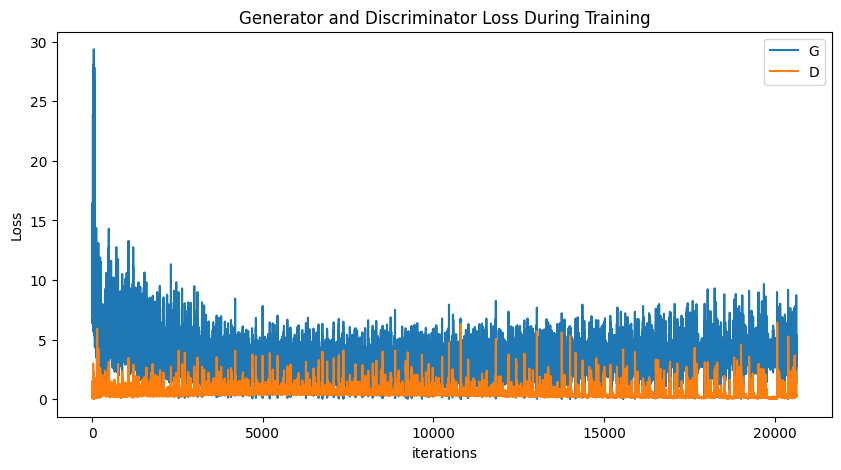

In [81]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**G의 학습 과정 시각화**

매 에폭마다 fixed_noise를 이용해 생성자가 만들어낸 이미지를 저장한 것을 기억할겁니다.
저장한 이미지들을애니메이션 형식으로 확인해 봅시다. play버튼을 누르면 애니매이션이 실행됩니다




In [82]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

**진짜 이미지 vs. 가짜 이미지**

진짜 이미지들과 가짜 이미지들을 옆으로 두고 비교를 해봅시다




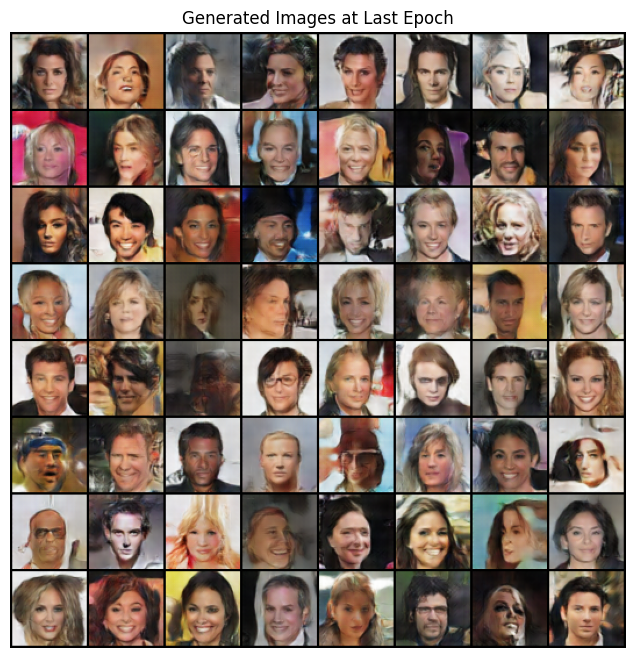

In [85]:
with torch.no_grad():
    fake_images = netG(fixed_noise).detach().cpu()

# 생성된 이미지 시각화
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images at Last Epoch")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()

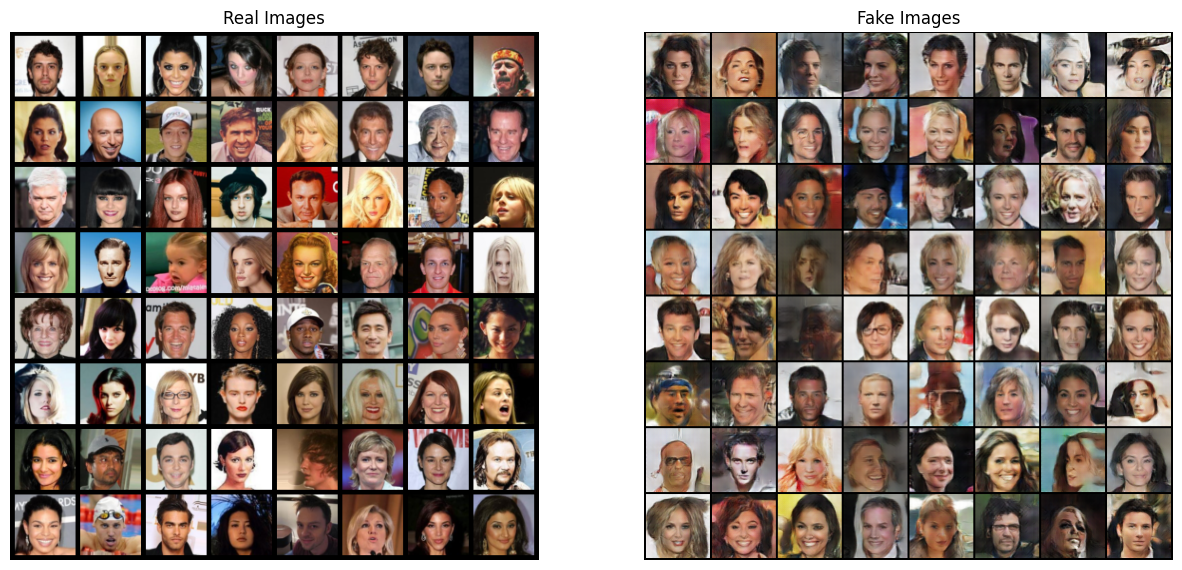

In [83]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

## 이제 어디로 여행을 떠나볼까요?

드디어 DCGAN이 끝났습니다! 하지만 더 알아볼 것들이 많이 남아있죠.
무엇을 더 시도해볼 수 있을까요?

-  결과물이 얼마나 더 좋아지는지 확인해보기 위해서 학습시간을 늘려볼 수 있습니다
-  다른 데이터셋을 이용해 훈련시켜보거나, 이미지의 사이즈를 다르게 해보거나, 아키텍쳐의 구성을 바꿔볼 수도 있습니다
-  [여기](https://github.com/nashory/gans-awesome-applications)_ 에서 더욱 멋진 GAN 프로젝트들을 찾을수도 있죠
-  [음악](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio/)_ 을 작곡하는 GAN도 만들 수 있습니다


